In [22]:
import sys
print(sys.version)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [23]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

* State: x position [m], y position [m], yaw [rad]

\begin{align*}
\textbf{x}_t =
\begin{bmatrix}
    x_t \\
    y_t \\
    \theta_t \\
\end{bmatrix}
\end{align*}

* Input: speed [m/s], yaw rate [rad/s]

\begin{align*}
\textbf{u}_t =
\begin{bmatrix}
    v_t \\
    \omega_t \\
\end{bmatrix}
\end{align*}

* Observation: distance to i-th RFID [m], x position of i-th RFID [m], y position of i-th RFID [m]

$$
\textbf{z}_t^i =
\begin{bmatrix}
    d_t^i \\
    x^i \\
    y^i \\
\end{bmatrix}
$$

# Parameters

In [24]:
DIM_X = 3 ### State dimension: x [m], y [m], theta [rad]
DIM_U = 2 ### Input dimension: v [m/s], w [rad/s]
DIM_Z = 3 ### Observation dimension: d [m]

DELTA_TIME = 0.1 # [s]
END_TIME = 30.0 # [s]
MAX_DISTANCE = 20.0 # [m]

INPUT_COV = np.diag([
    1.0**2, # [m^2/s^2] variance of speed input
    np.deg2rad(30.0)**2 # [rad^2/s^2] variance of yaw rate input
])

SENSOR_COV = np.diag([
    0.2**2, # [m^2] variance of distance to i-th RFID
    0.0**2, # [m^2] variance of x postion of i-th RFID
    0.0**2 # [m^2] variance of y postion of i-th RFID
])

In [25]:
### Input error covariance for particles
INPUT_COV_PARTI = np.diag([
    2.0**2, # [m^2/s^2] error of speed input
    np.deg2rad(40.0)**2 # [rad^2/s^2] error of yaw rate input
])

### Sonsor error covariance for particles
SENSOR_COV_PARTI = np.diag([
    0.2**2, # [m^2] error of distance to i-th RFID
    0.0**2, # [m^2] error of x postion of i-th RFID
    0.0**2 # [m^2] error of y postion of i-th RFID
])

### RFID tag positions: x [m], y [m]
RFIDs = np.array([
    [10.0, 0.0],
    [10.0, 10.0],
    [0.0, 15.0],
    [-5.0, 20.0]
])

In [26]:
### Particle Filter parmeters
NUM_PARTI = 100
NUM_THRE = NUM_PARTI / 2.0

# Functions

Motion model (Non-linear):

\begin{align*}
\textbf{x}_t & = \textbf{f} (\textbf{x}_{t-1}, \textbf{u}_t)
\\
& = 
\begin{bmatrix}
    x_{t-1} + v_t \Delta t \cos \theta_{t-1} \\
    y_{t-1} + v_t \Delta t \sin \theta_{t-1} \\
    \theta_{t-1} + \omega_t \Delta t \\
\end{bmatrix}
\end{align*}

In [27]:
### Non-linear
def MotionModel(x_prev, u_curr):
    x_pos_prev = x_prev[0, 0] # [m]
    y_pos_prev = x_prev[1, 0] # [m]
    yaw_prev = x_prev[2, 0] # [rad]

    speed_curr = u_curr[0, 0] # [m/s]
    yaw_rate_curr = u_curr[1, 0] # [rad/s]

    x_curr = np.array([
        [x_pos_prev + speed_curr*DELTA_TIME*math.cos(yaw_prev)],
        [y_pos_prev + speed_curr*DELTA_TIME*math.sin(yaw_prev)],
        [yaw_prev + yaw_rate_curr*DELTA_TIME]
    ])

    return x_curr

In [28]:
def ReadRFIDs(x_GT):
    zs = np.empty((0, DIM_Z))

    for i in range(len(RFIDs)):
        x_pos = x_GT[0, 0]
        y_pos = x_GT[1, 0]

        x_RFID = RFIDs[i, 0]
        y_RFID = RFIDs[i, 1]

        dx = x_RFID - x_pos
        dy = y_RFID - y_pos
        d = math.hypot(dx, dy)

        if d <= MAX_DISTANCE:
            distance_noise = (SENSOR_COV@np.random.randn(DIM_Z, 1))[0, 0]
            d_sense = d + distance_noise

            z_i = np.array([[d_sense, x_RFID, y_RFID]])
            assert z_i.shape == (1, DIM_Z)
            zs = np.vstack((zs, z_i))

    assert zs.shape[0] <= len(RFIDs) and zs.shape[1] == DIM_Z

    return zs

In [29]:
def GaussianLikelihood(delta, sigma):
    p = 1.0 / math.sqrt(2.0 * math.pi * sigma**2) * math.exp(-delta**2 / (2.0 * sigma**2))

    return p



def Resampling(x_parti, w_parti):
    w_parti_cumsum = np.cumsum(w_parti)

    ### resample_cumprob == [0.0, 1/N, 2*1/N, 3*1/N, ... , 1.0 - 1/N] + uniform(0.0 ~ 1/N)
    resample_cumprob = np.arange(start=0.0, stop=1.0, step=1.0/NUM_PARTI) + np.random.uniform(low=0.0, high=1.0/NUM_PARTI)

    resample_idxs = []
    cnt = 0
    for n in range(NUM_PARTI):
        while w_parti_cumsum[cnt] < resample_cumprob[n]:
            cnt += 1

        assert cnt <= (NUM_PARTI - 1)
        resample_idxs.append(cnt)

    x_parti_resample = x_parti[:, resample_idxs]
    w_parti_resample = np.full((1, NUM_PARTI), fill_value=1.0/NUM_PARTI) ### Init weights

    assert x_parti_resample.shape == (DIM_X, NUM_PARTI)
    assert w_parti_resample.shape == (1, NUM_PARTI)

    return x_parti_resample, w_parti_resample
 


def PF(x_parti_prev, w_parti_prev, u_curr_noisy, zs_curr):
    x_parti_curr = np.copy(x_parti_prev)
    w_parti_curr = np.copy(w_parti_prev)

    for n in range(NUM_PARTI):
        x_n_prev = np.array([
            [x_parti_prev[0, n]],
            [x_parti_prev[1, n]],
            [x_parti_prev[2, n]]
        ])

        w_n_prev = w_parti_prev[0, n]

        assert x_n_prev.shape == (DIM_X, 1)
        assert w_n_prev.shape == ()

        input_noise_parti = INPUT_COV_PARTI @ np.random.randn(DIM_U, 1)
        u_curr_noisy_parti = u_curr_noisy + input_noise_parti
        x_n_curr = MotionModel(x_n_prev, u_curr_noisy_parti)

        w_n_curr = w_n_prev
        for i in range(len(zs_curr)):
            x_pos_curr = x_n_curr[0, 0]
            y_pos_curr = x_n_curr[1, 0]

            d_sense_curr = zs_curr[i, 0]
            x_RFID_curr = zs_curr[i, 1]
            y_RFID_curr = zs_curr[i, 2]

            dx_curr = x_RFID_curr - x_pos_curr
            dy_curr = y_RFID_curr - y_pos_curr
            d_pred_curr = math.hypot(dx_curr, dy_curr)

            dz_curr = d_pred_curr - d_sense_curr
            w_n_curr *= GaussianLikelihood(dz_curr, math.sqrt(SENSOR_COV_PARTI[0, 0]))

        assert x_n_curr.shape == (DIM_X, 1)
        assert w_n_curr.shape == ()

        x_parti_curr[:, n] = x_n_curr[:, 0]
        w_parti_curr[0, n] = w_n_curr

    ### Normalize
    w_parti_curr = w_parti_curr / w_parti_curr.sum()

    ### Estimation
    x_est_curr = x_parti_curr@w_parti_curr.T 

    ### Resample if the effective number of particles is low
    ### For example:
    ### num_effect == 1 if only one weight is 1.0 and everyone else is 0.0
    ### num_effect == 2 if only two weights are 0.5 and everyone else is 0.0
    ### num_effect == 3 if only three weights are 0.33 and everyone else is 0.0
    ### ...
    ### num_effect == N if all weights are 1/N
    num_effect = 1.0 / (w_parti_curr@w_parti_curr.T)[0, 0]
    if num_effect < NUM_THRE:
        x_parti_curr, w_parti_curr = Resampling(x_parti_curr, w_parti_curr)

    return x_est_curr, x_parti_curr, w_parti_curr

In [30]:
def PlotTrajectory(xs_GT, xs_DR, xs_est, x_GT_curr, zs_curr):
    xs_GT_np = np.array(xs_GT)
    xs_DR_np = np.array(xs_DR)
    xs_est_np = np.array(xs_est)

    plt.plot(xs_GT_np[:, 0], xs_GT_np[:, 1], color='blue', label='Ground Truth')
    plt.plot(xs_DR_np[:, 0], xs_DR_np[:, 1], color='black', label='Dead Reckoning')
    plt.plot(xs_est_np[:, 0], xs_est_np[:, 1], color='red', linestyle='dashed', label='Estimation')

    plt.scatter(RFIDs[:, 0], RFIDs[:, 1], color='orange', marker='*', label='RFIDs')

    for i in range(len(zs_curr)):
        x_pos_curr = x_GT_curr[0, 0]
        y_pos_curr = x_GT_curr[1, 0]
    
        x_RFID_curr = zs_curr[i, 1]
        y_RFID_curr = zs_curr[i, 2]
    
        plt.plot([x_pos_curr, x_RFID_curr], [y_pos_curr, y_RFID_curr], color='gold')

    plt.xticks(np.arange(-100, 100, 5))
    plt.yticks(np.arange(-100, 100, 5))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.axis('equal')

    return

# Main

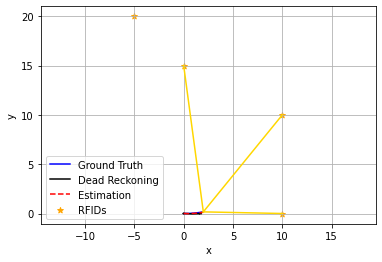

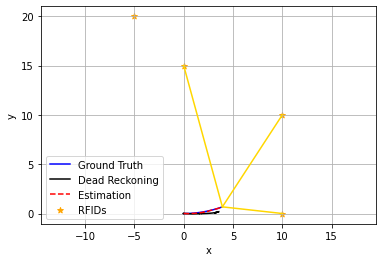

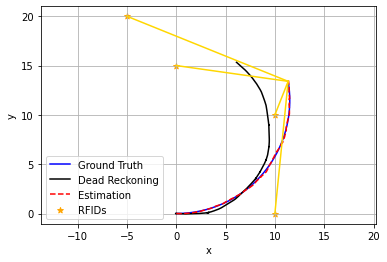

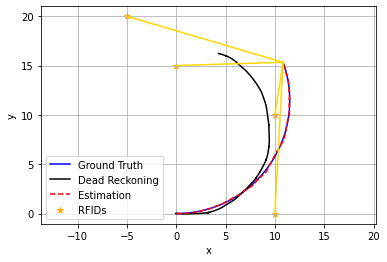

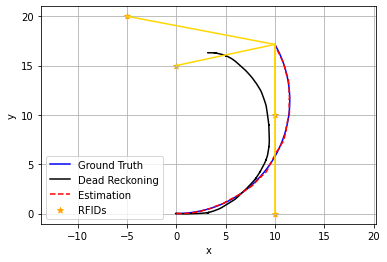

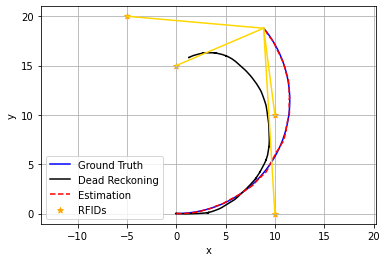

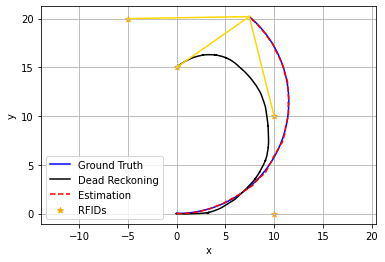

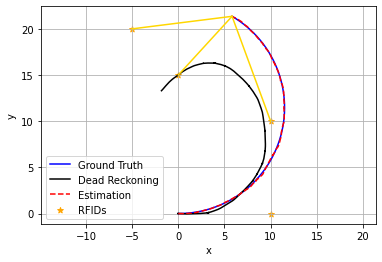

In [31]:
x_GT_init = np.zeros((DIM_X, 1))
x_DR_init = np.zeros((DIM_X, 1))
x_est_init = np.zeros((DIM_X, 1))

xs_GT = [x_GT_init] ### Ground Truth history
xs_DR = [x_DR_init] ### Dead Reckoning history
xs_est = [x_est_init]  ### Estimation history

### Particles and their weights
x_parti_init = np.zeros((DIM_X, NUM_PARTI))
w_parti_init = np.full((1, NUM_PARTI), fill_value=1.0/NUM_PARTI)

x_GT_prev = x_GT_init
x_DR_prev = x_DR_init
x_parti_prev = x_parti_init
w_parti_prev = w_parti_init

t = 0.0

while t < END_TIME:
    ### Input command ... NOTE: "u_curr.shape" must be (2, 1), not (2,)
    speed_curr = 1.0 # [m/s]
    yaw_rate_curr = np.deg2rad(5.0) # [m/s]
    u_curr = np.array([
        [speed_curr],
        [yaw_rate_curr],
    ])
    
    ### Ground Truth state
    x_GT_curr = MotionModel(x_GT_prev, u_curr)

    ### Dead Reckoning state
    input_noise = INPUT_COV @ np.random.randn(DIM_U, 1)
    u_curr_noisy = u_curr + input_noise
    x_DR_curr = MotionModel(x_DR_prev, u_curr_noisy)

    ### Observation
    zs_curr = ReadRFIDs(x_GT_curr)

    ### Particle Filter estimation
    x_est_curr, x_parti_curr, w_parti_curr = PF(x_parti_prev, w_parti_prev, u_curr_noisy, zs_curr)

    xs_GT.append(x_GT_curr)
    xs_DR.append(x_DR_curr)
    xs_est.append(x_est_curr)

    if np.isclose((t + DELTA_TIME) % 2.0, 0.0, atol=1.0e-6):
        PlotTrajectory(xs_GT, xs_DR, xs_est, x_GT_curr, zs_curr)
        plt.grid(True)
        plt.axis('equal')
        plt.pause(0.001)

    x_GT_prev = x_GT_curr
    x_DR_prev = x_DR_curr
    x_parti_prev = x_parti_curr
    w_parti_prev = w_parti_curr

    t += DELTA_TIME